In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import matplotlib.pyplot as plt

In [2]:
import os
import pandas as pd
import numpy as np
from Bio import SeqIO, PDB
from Bio.PDB import PDBParser, PDBIO, Select, NeighborSearch, Structure, Model
import warnings
warnings.filterwarnings("ignore")
import pickle
from tqdm import tqdm
import seaborn as sns
import numpy as np
import joblib
import shutil

In [3]:
import sys
sys.path.append("/datapool/data2/home/jiahan/Res Proj/PepDiff/pepbridge/")

from pepbridge.modules.protein.parsers import *

# 0. fix ATOMs in biolip

In [4]:
lig_path = "/datapool/data2/home/jiahan/Data/BioLiP/nonredund_lig/"
os.makedirs("/datapool/data2/home/jiahan/Data/BioLiP/nonredund_lig_fix/",exist_ok=True)
lig_path_fix  = "/datapool/data2/home/jiahan/Data/BioLiP/nonredund_lig_fix/"

for lig in os.listdir(lig_path):
    with open(os.path.join(lig_path,lig),'r') as f:
        content = f.read()
        content = content.replace('HETATM','ATOM  ')
    with open(os.path.join(lig_path_fix,lig),'w') as f:
        f.write(content)

# 1.pepbdb filtering

In [5]:
pepbdb_path = "/datapool/data2/home/jiahan/Data/pepbdb/"
data_path = "/datapool/data2/home/jiahan/Data/pepbdb_split/"

In [6]:
dic = {'pdb':[],'pep':[],'pep_len':[],'res':[],'no':[],'pep_atom':[],'rec_atom':[],'type':[]}

with open("/datapool/data2/home/jiahan/Data/pepbdb/peptidelist.txt",'r') as f:
    for line in f:
        line = line.split()
        if 'prot' not in line[-1]:
            line += ['prot']
        dic['pdb'].append(line[0].strip())
        dic['pep'].append(line[1].strip())
        dic['pep_len'].append(int(line[2].strip()))
        dic['res'].append(float(line[-2].strip()))
        dic['no'].append(int(line[-4].strip())+int(line[-3].strip()))
        dic['pep_atom'].append(int(line[-8].strip()))
        dic['rec_atom'].append(int(line[-6].strip()))
        dic['type'].append(line[-1].strip())

dic = pd.DataFrame(dic)

dic['rec_len'] = dic['rec_atom'] / 8

# dic = dic[(dic['res']<=4.0) & (dic['type']=='prot') & (dic['pep_len']<=25) & (dic['pep_len']>=4)]
# dic = dic[dic['rec_len'] >= 2*dic['pep_len']]

dic = dic[(dic['res']<=4.0) & (dic['type']=='prot') & (dic['pep_len']<=25) & (dic['pep_len']>=3)]
dic = dic[dic['rec_len'] >= 2*dic['pep_len']]

dic['pep_len'].mean(),len(dic)

(10.641843971631205, 9024)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


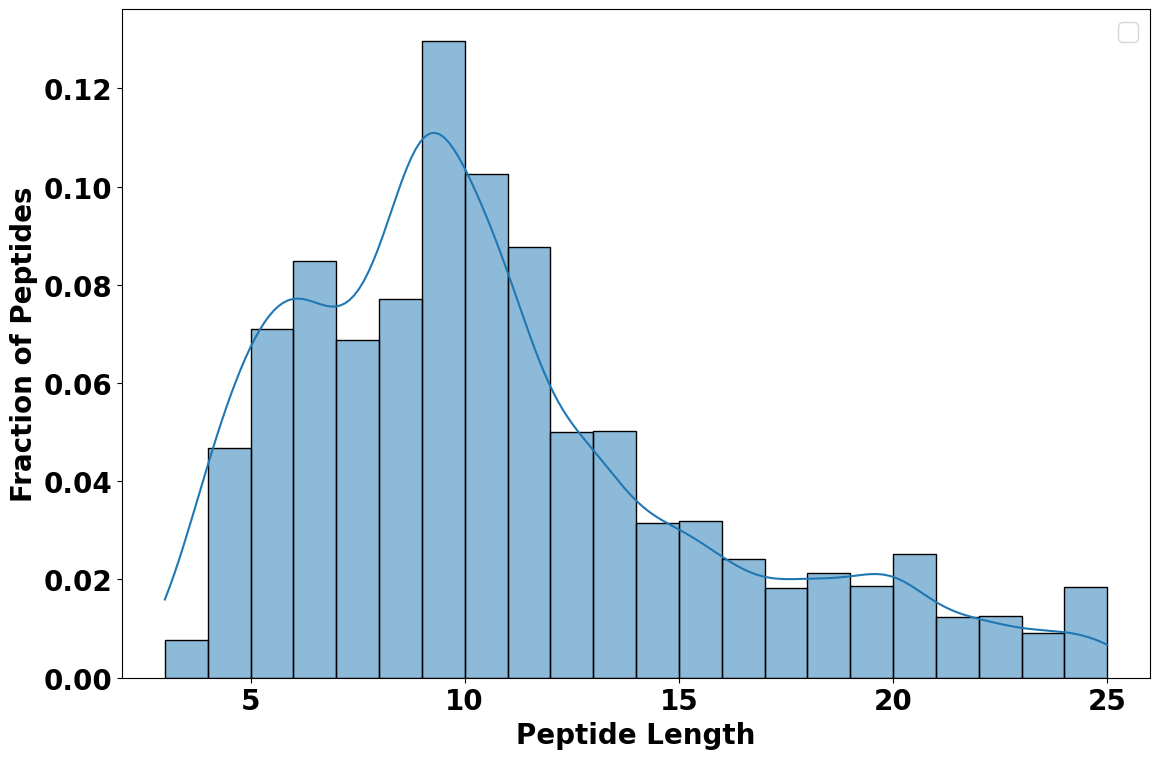

In [24]:
plt.figure(figsize=(12,8))

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.size"] = 20

sns.histplot(data=dic,x='pep_len',kde=True,binwidth=1, stat='density', common_norm=False,)

plt.xlim(2,26)

ax = plt.gca()

# Set font size and weight for labels and ticks
ax.set_xlabel("Peptide Length", fontsize=20, weight='bold')
ax.set_ylabel("Fraction of Peptides", fontsize=20, weight='bold')
ax.legend(fontsize=18)

plt.tight_layout()  # Add this line

plt.savefig('/datapool/data2/home/jiahan/ResProj/PepDiff/frame-flow/Data/Models_new/Results/plot/data1.png',dpi=1200,bbox_inches='tight')

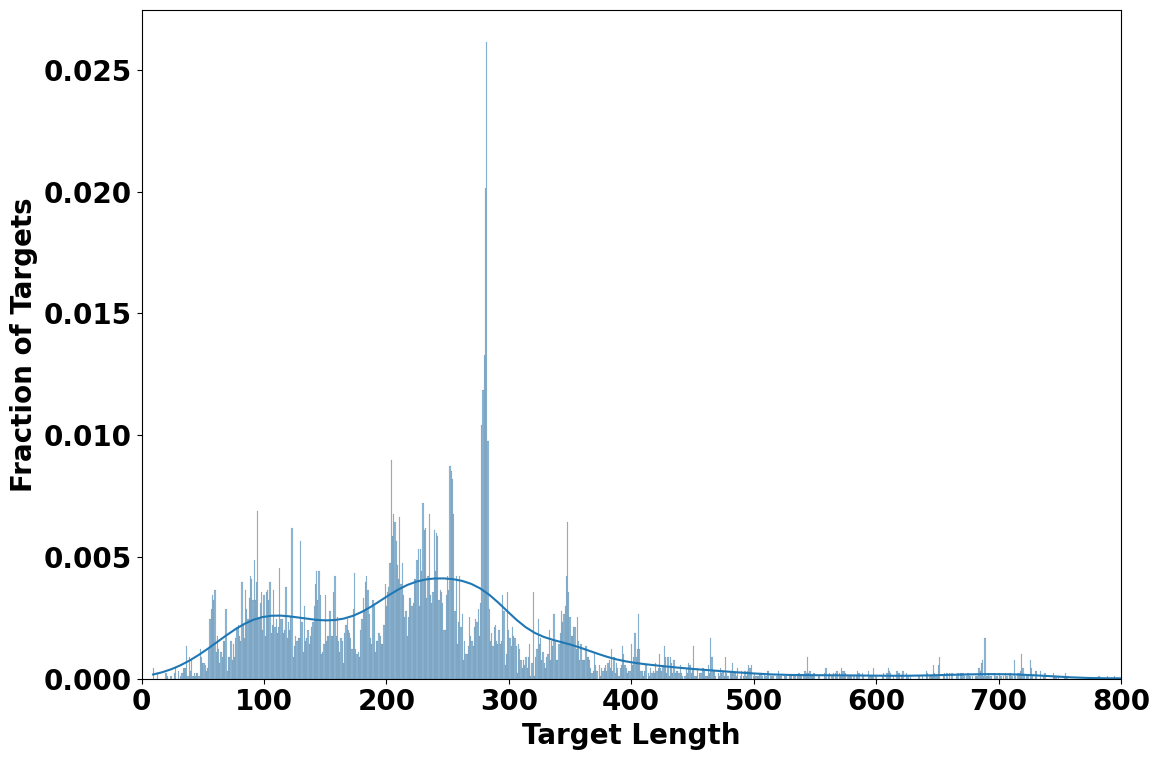

In [28]:
plt.figure(figsize=(12,8))

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.size"] = 20

sns.histplot(data=dic,x='rec_len',kde=True,binwidth=1, stat='density', common_norm=False)

plt.xlim(0,800)

ax = plt.gca()

# Set font size and weight for labels and ticks
ax.set_xlabel("Target Length", fontsize=20, weight='bold')
ax.set_ylabel("Fraction of Targets", fontsize=20, weight='bold')

plt.tight_layout()  # Add this line

# plt.savefig('/datapool/data2/home/jiahan/ResProj/PepDiff/frame-flow/Data/Models_new/Results/plot/data2.png',dpi=1200,bbox_inches='tight')

In [9]:
dic['pdb']

0        1a1r
4        1a38
15       1abi
17       1acy
25       1ai1
         ... 
13293    6v8o
13297    6vdb
13298    6vfs
13299    6vfx
13300    6xvd
Name: pdb, Length: 9024, dtype: object

In [10]:
pepbdb_ls = list(set(dic['pdb']))
len(pepbdb_ls)

8843

In [11]:
dic.head()

pdb pep  pep_len   res  no  pep_atom  rec_atom  type  rec_len
0   1a1r   C       16  2.50   0       108      1117  prot  139.625
4   1a38   P        5  3.35   0        47      1730  prot  216.250
15  1abi   I       20  2.30   1       153      2039  prot  254.875
17  1acy   P       10  3.00   0        79      1700  prot  212.500
25  1ai1   P       10  2.80   1        80      1700  prot  212.500

# 2.biolip filtering

In [12]:
lig_path = "/datapool/data2/home/jiahan/Data/BioLiP/nonredund_lig_fix"
rec_path = "/datapool/data2/home/jiahan/Data/BioLiP/nonredund_rec/"
data_path = "/datapool/data2/home/jiahan/Data/PepMerge/"

In [13]:
tab = pd.read_csv("/datapool/data2/home/jiahan/Data/BioLiP/Nonredund_stru_annotations.csv")
tab = tab[tab['Resolution (Å)']<=4]
tab_ls = list(set(tab['PDB ID']))
len(tab_ls)

24629

In [14]:
lip_dic = {}
with open("/datapool/data2/home/jiahan/Data/BioLiP/PIII_nonredund.txt",'r') as f:
    for line in f:
        line = line.strip().split(',')
        pdb = line[1].split('_')[0]
        if pdb not in pepbdb_ls and pdb in tab_ls: # not in pepbdb and <= 4 A
            seq_lig = get_fasta_from_pdb(os.path.join(lig_path,line[1]+'.pdb'))['A']
            # if 4<=len(seq_lig)<=25:
            if 3<=len(seq_lig)<=25:
                lip_dic[line[1]] = line[0]
len(lip_dic) # 1322

1402

# 3. Merge Datasets

In [15]:
data_path = "/datapool/data2/home/jiahan/Data/PepMerge_new/"

In [18]:
def save_pair_lip(lig,rec,data_path = "/datapool/data2/home/jiahan/Data/PepMerge/"):
    lig_parser, rec_parser = PDBParser(), PDBParser()
    lig_structure, rec_structure = lig_parser.get_structure('lig', os.path.join(lig_path,f'{lig}.pdb')), rec_parser.get_structure('rec', os.path.join(rec_path,f'{rec}.pdb'))
    ligs = [atom for atom in lig_structure[0].get_atoms() if atom.get_name() == 'CB']
    recs = [atom for atom in rec_structure[0].get_atoms() if atom.get_name() == 'CB']
    search = NeighborSearch(recs)
    near_chains = []
    for atom in ligs:
        near_chains += search.search(atom.get_coord(), 6.0, level='C') # nearest 6 A Cbeta
    near_chains = list(set([chain.get_full_id() for chain in near_chains]))
    
    class ChainSelector(Select):
        def accept_chain(self, chain):
            return chain.get_full_id() in near_chains
    
    os.makedirs(os.path.join(data_path,lig),exist_ok=True)
    io = PDBIO()
    io.set_structure(rec_structure)
    io.save(os.path.join(data_path,lig,'receptor.pdb'), ChainSelector())
    lig_structure[0]['A'].id = lig.split('_')[-1][0] # rename chain
    io = PDBIO()
    io.set_structure(lig_structure)
    io.save(os.path.join(data_path,lig,'peptide.pdb'))

    # # lig + rec in the same pdb
    # # 创建一个新的模型
    # new_model = Model.Model(0)

    # # 将两个结构中的所有链添加到新的模型中
    # for chain in lig_structure.get_chains():
    #     new_model.add(chain)
    # for chain in rec_structure.get_chains():
    #     new_model.add(chain)

    # # 创建一个新的结构并将新的模型添加到其中
    # new_structure = Structure.Structure('new_structure')
    # new_structure.add(new_model)

    # # 保存新的结构为一个PDB文件
    # io = PDBIO()
    # io.set_structure(new_structure)
    # io.save(os.path.join(data_path,lig,'combined.pdb'))  
    
    lig_seq = get_fasta_from_pdb(os.path.join(data_path,lig,'peptide.pdb'))
    rec_seq = get_fasta_from_pdb(os.path.join(data_path,lig,'receptor.pdb'))
    if 2 * len(''.join(list(lig_seq.values()))) > len(''.join(list(rec_seq.values()))):
        shutil.rmtree(os.path.join(data_path,lig))
        return None
    else:
        lig_chain = ''
        rec_chain = ''
        with open(os.path.join(data_path,lig,'peptide.fasta'),'w') as f:
            for k,v in lig_seq.items():
                # lig_chain += f'{k}'
                f.write(f'>{lig}_{k}\n{v}\n')
        with open(os.path.join(data_path,lig,'receptor.fasta'),'w') as f:
            for k,v in rec_seq.items():
                # rec_chain += f'{k}'
                f.write(f'>{lig}_{k}\n{v}\n')

        return lig

In [19]:
lig_path = "/datapool/data2/home/jiahan/Data/BioLiP/nonredund_lig_fix"
rec_path = "/datapool/data2/home/jiahan/Data/BioLiP/nonredund_rec/"

lip_list = joblib.Parallel(
    n_jobs = max(joblib.cpu_count() // 2, 1),
)(
    joblib.delayed(save_pair_lip)(lig,rec,data_path)
    for (lig,rec) in tqdm(lip_dic.items(), dynamic_ncols=True, desc='Preprocess')
)
lip_list = [item for item in lip_list if item is not None]
len(lip_list) # 1293

Preprocess:   9%|▉         | 127/1402 [00:02<00:21, 60.14it/s]/datapool/data2/home/jiahan/anaconda3/envs/fm/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 129
  warnings.warn(
/datapool/data2/home/jiahan/anaconda3/envs/fm/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 130
  warnings.warn(
/datapool/data2/home/jiahan/anaconda3/envs/fm/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 136
  warnings.warn(
/datapool/data2/home/jiahan/anaconda3/envs/fm/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 115
  warnings.warn(
/datapool/data2/home/jiahan/anaconda3/envs/fm/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'TER' at line 84
  warnings.

PDBConstructionException: A defined twice

In [41]:
len(lip_list)

1373

In [42]:
def save_pair_pepbdb(pdb,data_path = "/datapool/data2/home/jiahan/Data/PepMerge/"):
    try:
        lig_parser, rec_parser = PDBParser(), PDBParser()
        lig_structure, rec_structure = lig_parser.get_structure('lig', os.path.join(pepbdb_path,pdb,f'peptide.pdb')), rec_parser.get_structure('rec', os.path.join(pepbdb_path,pdb, f'receptor.pdb'))
        ligs = [atom for atom in lig_structure[0].get_atoms() if atom.get_name() == 'CB']
        recs = [atom for atom in rec_structure[0].get_atoms() if atom.get_name() == 'CB']
        if len(ligs) == 0 or len(recs) == 0:
            return None
        search = NeighborSearch(recs)
        near_chains = []
        for atom in ligs:
            near_chains += search.search(atom.get_coord(), 6.0, level='C')
        near_chains = list(set([chain.get_full_id() for chain in near_chains]))
        if len(near_chains) == 0:
            return None


        class ChainSelector(Select):
            def accept_chain(self, chain):
                return chain.get_full_id() in near_chains
        
        os.makedirs(os.path.join(data_path,pdb),exist_ok=True)
        io = PDBIO()
        io.set_structure(rec_structure)
        io.save(os.path.join(data_path,pdb,'receptor.pdb'), ChainSelector())
        io = PDBIO()
        io.set_structure(lig_structure)
        io.save(os.path.join(data_path,pdb,'peptide.pdb'))


        lig_seq = get_fasta_from_pdb(os.path.join(data_path,pdb,'peptide.pdb'))
        rec_seq = get_fasta_from_pdb(os.path.join(data_path,pdb,'receptor.pdb'))
        if 2 * len(''.join(list(lig_seq.values()))) > len(''.join(list(rec_seq.values()))):
            shutil.rmtree(os.path.join(data_path,pdb))
            return None
        else:
            with open(os.path.join(data_path,pdb,'peptide.fasta'),'w') as f:
                for k,v in lig_seq.items():
                    f.write(f'>{pdb}_{k}\n{v}\n')
            with open(os.path.join(data_path,pdb,'receptor.fasta'),'w') as f:
                for k,v in rec_seq.items():
                    f.write(f'>{pdb}_{k}\n{v}\n')
            return pdb
    except:
        return None

In [46]:
dic.head()

pdb pep  pep_len   res  no  pep_atom  rec_atom  type  rec_len
0   1a1r   C       16  2.50   0       108      1117  prot  139.625
4   1a38   P        5  3.35   0        47      1730  prot  216.250
15  1abi   I       20  2.30   1       153      2039  prot  254.875
17  1acy   P       10  3.00   0        79      1700  prot  212.500
25  1ai1   P       10  2.80   1        80      1700  prot  212.500

In [44]:
pepbdb_ls = []
for i,row in dic.iterrows():
    pepbdb_ls.append(f"{row['pdb']}_{row['pep']}")
pepbdb_ls[0]

'1a1r_C'

In [45]:
len(pepbdb_ls)

9024

In [46]:
bdb_list = joblib.Parallel(
    n_jobs = max(joblib.cpu_count() // 2, 1),
)(
    joblib.delayed(save_pair_pepbdb)(pdb,data_path)
    for pdb in tqdm(pepbdb_ls, desc='Preprocess')
)
bdb_list = [item for item in bdb_list if item is not None]
len(bdb_list) # 8906

Preprocess:   0%|          | 0/9024 [00:00<?, ?it/s]

/datapool/data2/home/jiahan/anaconda3/envs/foldy/lib/python3.9/site-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_3to1'.
  warnings.warn(
/datapool/data2/home/jiahan/anaconda3/envs/foldy/lib/python3.9/site-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_3to1'.
  warnings.warn(
/datapool/data2/home/jiahan/anaconda3/envs/foldy/lib/python3.9/site-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a future release of Biopython in favor of 'Bio.PDB.Polypeptide.protein_letters_3to1'.
  warnings.warn(
/datapool/data2/home/jiahan/anaconda3/envs/foldy/lib/python3.9/site-packages/Bio/PDB/Polypeptide.py:144: BiopythonDeprecationWarning: 'three_to_one' will be deprecated in a futur

8975

In [47]:
len(bdb_list)

8975

In [48]:
len(os.listdir(data_path))

10348


# 5. pocket dataset

In [49]:
data_path =  "/datapool/data2/home/jiahan/Data/PepMerge_new/"
contact_dis = 10

In [52]:
data_path

'/datapool/data2/home/jiahan/Data/PepMerge_new/'

In [51]:
def extract_pocket(name):
    lig_parser, rec_parser = PDBParser(), PDBParser()
    lig_structure, rec_structure = lig_parser.get_structure('lig', os.path.join(data_path,name,f'peptide.pdb')), rec_parser.get_structure('rec', os.path.join(data_path,name, f'receptor.pdb'))

    lig_atoms = Selection.unfold_entities(lig_structure, 'A')
    rec_atoms = Selection.unfold_entities(rec_structure, 'A')

    search = NeighborSearch(rec_atoms)
    near_res = []
    for atom in lig_atoms:
        near_res += search.search(atom.get_coord(), contact_dis, level='R')
    near_res = list(set([res.get_full_id() for res in near_res])) # get_id() may affect homo dimer
    
    class ResidueSelector(Select):

        def accept_residue(self, residue):
            return residue.get_full_id() in near_res
        
    os.makedirs(os.path.join(data_path,name),exist_ok=True)
    io = PDBIO()
    io.set_structure(rec_structure)
    io.save(os.path.join(data_path,name,'pocket.pdb'), ResidueSelector())

    return name

In [53]:
ls = joblib.Parallel(
    n_jobs = max(joblib.cpu_count() // 2, 1),
)(
    joblib.delayed(extract_pocket)(name)
    for name in tqdm(os.listdir(data_path),dynamic_ncols=True,desc='Preprocess')
)

Preprocess:  10%|▉         | 1016/10348 [00:00<00:07, 1319.89it/s]/datapool/data2/home/jiahan/anaconda3/envs/foldy/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:236: PDBConstructionWarning: Negative occupancy in one or more atoms
  warnings.warn(
Preprocess: 100%|██████████| 10348/10348 [00:08<00:00, 1239.43it/s]
/datapool/data2/home/jiahan/anaconda3/envs/foldy/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:236: PDBConstructionWarning: Negative occupancy in one or more atoms
  warnings.warn(


In [55]:
ls = [item for item in ls if item is not None]
len(ls)

10348